In [130]:
#import ulab
try:
    from ulab import numpy as np
except:
    import numpy as np
import random
import math
import time
#from ulab import scipy as sp


def mu_editor_plotter(y):
    for yy in y:
        time.sleep(0.1)
        print( ( yy,0 ) )

def randoms(size):
    return np.array([ random.random() for _ in range(size)  ])

def box_muller_1d(size):
    U1 = randoms(size)
    U2 = randoms(size)
    R = np.sqrt(-2 * np.log(U1))
    Theta = 2 * np.pi * U2
    X = R * np.cos(Theta)
    Y = R * np.sin(Theta)
    return X

def sample_gauss_box_mueller_1d(mu,sigma,size):
    #print("this is box mueller")
    return box_muller_1d(size) * sigma + mu

def sample_multivariante_normal_1d(mu,K,epsilon=1e-5):
    d = len(mu)
    
    L = np.linalg.cholesky( matrix_sym(K) + epsilon*np.eye(d) )
    
    u = sample_gauss_box_mueller_1d(0, 1, d )
    mu1 = mu.transpose()
    return mu1 + np.dot(L, u)

def kernel_1d(X1, X2, l=1.0, sigma_f=1.0):
    """
    Isotropic squared exponential kernel.
    
    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).

    Returns:
        (m x n) matrix.
    """
    sqdist = reshape( X1**2 ) + X2**2 - 2 * dotdot_1d( X1, X2 )
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)

def reshape(X):
    return np.array([[x] for x in X ])

def matrix_sym(X):
    # fixes bad nums ;)
    for i,n1 in enumerate(X):
        for j,n2 in enumerate(n1):
            if i > j:
                X[j][i] = n2
    return X

def dotdot_1d(v1,v2):
    # ugly but works...
    dot = np.zeros( ( len(v1),len(v2) ) )
    for i,n1 in enumerate(v1):
        for j,n2 in enumerate(v2):
            dot[i][j] = n1*n2
    return dot

def posterior_1d(X_s, X_train, Y_train, l=1.0, sigma_f=1.0):
    """
    Computes the suffifient statistics of the posterior distribution 
    from m training data X_train and Y_train and n new inputs X_s.
    
    Args:
        X_s: New input locations (n x d).
        X_train: Training locations (m x d).
        Y_train: Training targets (m x 1).
        l: Kernel length parameter.
        sigma_f: Kernel vertical variation parameter.
        sigma_y: Noise parameter. (deleted no noise here... allow noise?? ( see below ))
    
    Returns:
        Posterior mean vector (n x d) and covariance matrix (n x n).
    """
    # variable noise
    #K = kernel_1d(X_train, X_train, l, sigma_f) #+ sigma_y**2 * np.eye(len(X_train))
    
    # hard coded noise... might be necessary for "creativity"
    K = kernel_1d(X_train, X_train, l, sigma_f) + 0.1**2 * np.eye(len(X_train))

    # no noise
    # K = kernel_1d(X_train, X_train, l, sigma_f)
    
    K_s = kernel_1d(X_train, X_s, l, sigma_f)
    K_ss = kernel_1d(X_s, X_s, l, sigma_f) + 1e-8 * np.eye(len(X_s))
    K_inv = np.linalg.inv(K)
    
    # Equation (7)
    mu_s = np.dot(np.dot(K_s.transpose(),K_inv),Y_train)
    
    # Equation (8)
    cov_s = K_ss - np.dot(np.dot(K_s.transpose(),K_inv),K_s)
    
    return mu_s, cov_s


# Finite number of points
X = np.arange( 0.1, 1.1, 0.02 )*10
Y_ref = np.sqrt(X)
#Y_ref = np.sin(X)
# Noise free training data
X_train = np.array([ 0.1, 0.3, 0.4,0.7 , 1])*10
Y_train = np.sqrt(X_train)

mean_diff = np.mean( np.diff(X_train) )
min_diff = np.min( np.diff(X_train) )
max_diff = np.max( np.diff(X_train) )
std_diff = np.std( np.diff(X_train) )
print(min_diff)
print(mean_diff," +/- ",std_diff) # ???
print(max_diff)
# Compute mean and covariance of the posterior distribution
mu_s, cov_s = posterior_1d(X, X_train, Y_train, l=2.25, sigma_f=.5)

samples = sample_multivariante_normal_1d( mu_s, cov_s, epsilon=1e-5 )

1.0
2.25  +/-  0.82915619758885
3.0


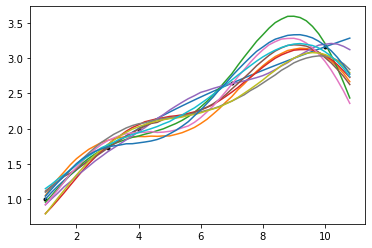

In [131]:
import matplotlib.pyplot as plt

plt.plot( X_train, Y_train, ".k" )
plt.plot( X, Y_ref )
for _ in range(10):
    samples = sample_multivariante_normal_1d( mu_s, cov_s, epsilon=1e-5 )
    plt.plot( X, samples )